In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline


In [2]:
#read excel file
df = pd.read_excel("C:/Users/Shylet/Downloads/Priority compartments/Grootfontein/discharge/Grootfontein discharge.xlsx")

In [3]:
df.head()

,Date,D4H013,D4H014
0,1964-06-01,0.010,NaN
1,1964-07-01,0.010,NaN
2,1964-08-01,0.012,NaN
3,1964-09-01,0.014,NaN
4,1964-10-01,0.010,NaN


In [4]:
 #setting date object to date index using pandas 
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
#cheching start and end dates of each station
result_dict = {}
def check_date(column):
    x = column.notnull()
    print(type(column[x]))
    result_dict[column.name] = [column[x].head(1).index[0], 
    column[x].tail(1).index[0]]
    
df.apply(check_date)
dates = pd.DataFrame(result_dict)
dates

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


,D4H013,D4H014
0,1964-06-01,1982-12-01
1,2017-05-01,2019-07-01


To avoid interpolating unnessary values i set bounds for each station to match the start and end dates previously computed


In [6]:
D4H013 = df['D4H013']
D4H013 = D4H013[D4H013.index > '1964-05-01'] 
D4H013 = D4H013[D4H013.index < '2017-06-01'] 

D4H014 = df['D4H014']
D4H014 = D4H014[D4H014.index > '1982-11-01'] 
D4H014 = D4H014[D4H014.index < '2019-08-01'] 

print(D4H013.shape)
print(D4H014.shape)

(636,)
(440,)


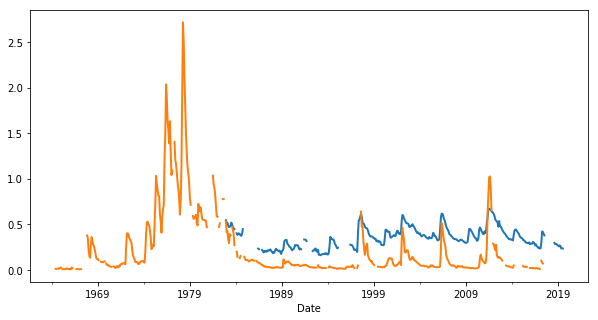

In [7]:
D4H014.plot(figsize=(10,5), linewidth=2, fontsize = 10);
D4H013.plot(figsize=(10,5), linewidth=2, fontsize = 10);

### Interpolation tests

I am testing station D4H014 to check the best interpolation methods.

1) select dates were there are no missing values

In [8]:
D4H014 = D4H014[D4H014.index > '1996-07-01'] 
D4H014 = D4H014[D4H014.index < '2017-06-01'] 

2) I create a new dataframe for testing.

3) I create an extra column were i add missinng values (target) which will later be used to calculate error scores

In [9]:
tester014 = pd.DataFrame(D4H014)
tester014["missing"] = D4H014
tester014["missing"].iloc[50:80]   = None
tester014["missing"].iloc[100:150] = None
tester014["missing"].iloc[300:400] = None

In [10]:
tester014.rename(columns = {'D4H014':'reference', 'missing': 'target'}, inplace = True) 

In [11]:
#create missing column t check where null values were added

tester014 = tester014.assign(missing= np.nan)
tester014.missing[tester014.target.isna()] = tester014.reference
tester014.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 1996-08-01 to 2017-05-01
Data columns (total 3 columns):
reference    250 non-null float64
target       170 non-null float64
missing      80 non-null float64
dtypes: float64(3)
memory usage: 7.8 KB


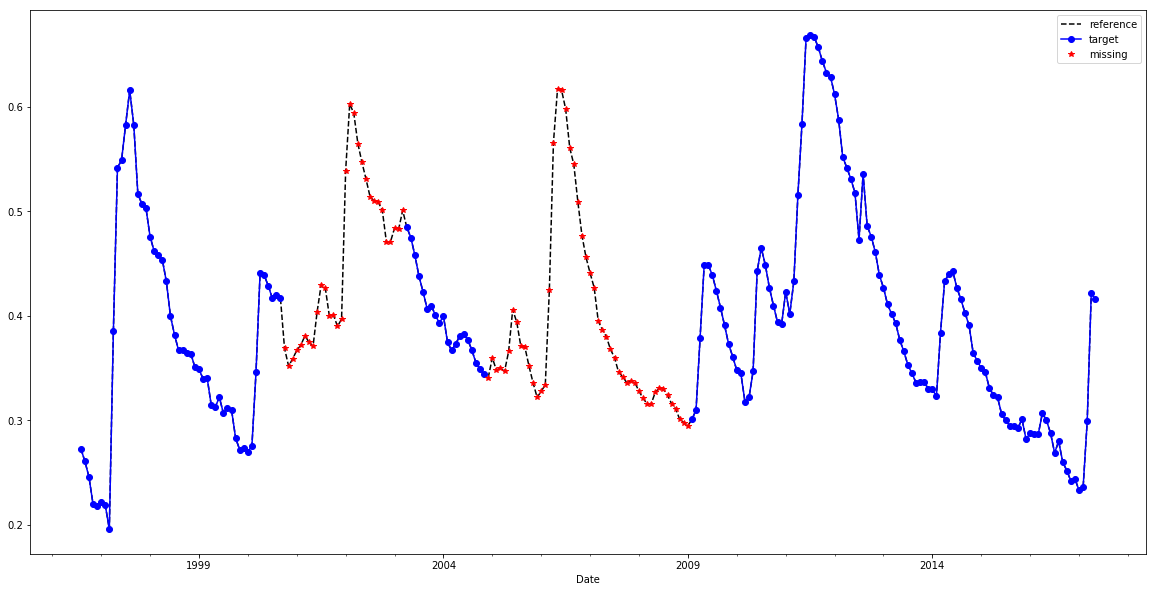

In [12]:
tester014.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10));

##### tested 10 interpolation techniques

In [13]:
tester014 = tester014.assign(FillMean=tester014.target.fillna(tester014.target.mean()))
tester014 = tester014.assign(FillMedian=tester014.target.fillna(tester014.target.median()))
tester014 = tester014.assign(InterpolateLinear=tester014.target.interpolate(method='linear'))
tester014 = tester014.assign(InterpolateTime=tester014.target.interpolate(method='time'))
tester014 = tester014.assign(InterpolateQuadratic=tester014.target.interpolate(method='quadratic'))
tester014 = tester014.assign(InterpolateCubic=tester014.target.interpolate(method='cubic'))
tester014 = tester014.assign(InterpolateSLinear=tester014.target.interpolate(method='slinear'))
tester014 = tester014.assign(InterpolateAkima=tester014.target.interpolate(method='akima'))
tester014 = tester014.assign(InterpolatePoly5=tester014.target.interpolate(method='polynomial', order=5)) 
tester014 = tester014.assign(InterpolatePoly7=tester014.target.interpolate(method='polynomial', order=7))
tester014 = tester014.assign(InterpolateSpline3=tester014.target.interpolate(method='spline', order=3))
tester014 = tester014.assign(InterpolateSpline4=tester014.target.interpolate(method='spline', order=4))
tester014 = tester014.assign(InterpolateSpline5=tester014.target.interpolate(method='spline', order=5))

In [14]:
#dropped these 2 so we can caluctae error scores.(throws error if not dropped because these olumns contain null values)
tester014 = tester014.drop(['target', "missing"], axis=1)

In [15]:
#check if we don't have any null values 
tester014.isna().sum()

reference               0
FillMean                0
FillMedian              0
InterpolateLinear       0
InterpolateTime         0
InterpolateQuadratic    0
InterpolateCubic        0
InterpolateSLinear      0
InterpolateAkima        0
InterpolatePoly5        0
InterpolatePoly7        0
InterpolateSpline3      0
InterpolateSpline4      0
InterpolateSpline5      0
dtype: int64

Below i calculate error scores for each method by cheching them against the actual values (reference column)

In [16]:
results = [(method, r2_score(tester014.reference, tester014[method])) for method in list(tester014)[3:]]
results_tester014 = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_tester014.sort_values(by='R_squared', ascending=False)

,Method,R_squared
4,InterpolateSLinear,0.7253301639200285
1,InterpolateTime,0.7253301639200282
0,InterpolateLinear,0.7252128912004128
3,InterpolateCubic,0.7044021912646079
9,InterpolateSpline4,0.6782926910690766
2,InterpolateQuadratic,0.6422077348440456
8,InterpolateSpline3,0.638011161026677
10,InterpolateSpline5,0.6166119965110358
6,InterpolatePoly5,-57.157486495343484
5,InterpolateAkima,-3.2835565531493845e+29


Best performing method for interpolation of discharge data is <b>*linear interpolation*</b>. this will be used to interpolate the dataset in the main file

In [17]:
D4H013= D4H013.interpolate(limit_direction='forward', method='slinear').mask(D4H013.bfill().isna())
D4H014= D4H014.interpolate(limit_direction='forward',method='slinear').mask(D4H014.bfill().isna())